<h1 align='center'><font size=10>PCA_LSI</h1>
<h1 align='center'><font size=5>Zach Chase</h1>

In [1]:
import string
import numpy as np
from math import log
from scipy import sparse
from sklearn import datasets
from scipy import linalg as la
from collections import Counter
from matplotlib import pyplot as plt
from scipy.sparse import linalg as spla
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import os

## PCA

Principal Component Analysis (PCA) is a multivariate statistical tool used to orthogonally
change the basis of a set of observations from the basis of original features (which may be correlated)
into a basis of uncorrelated (in fact, orthonormal) variables called the principal components. It is a
direct application of the singular value decomposition (SVD) from linear algebra. More specifically,
the first principal component will account for the greatest variance in the set of observations, the
second principal component will be orthogonal to the first, accounting for the second greatest variance
in the set of observations, etc. The first several principal components capture most of the variance in
the observation set, and hence provide a great deal of information about the data. By projecting the
observations onto the space spanned by the principal components, we can reduce the dimensionality
of the data in a manner that preserves most of the variance. [<sup>1</sup>](#fn1)

### Implement PCA and use on Iris dataset 

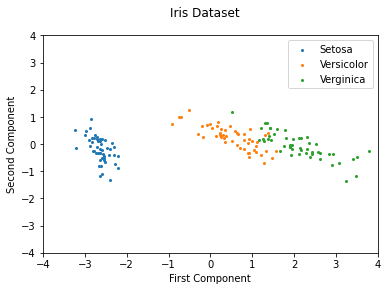

In [2]:
def iris_pca():
    """Function that calculates PCA and applies it to the Iris dataset to find the first 2 principal components."""
    
    # Load Iris Dataset
    X, Y = datasets.load_iris(return_X_y=True)

    # Calculate min of X shape (# of features)
    k = min(X.shape)
    
    # Convert data to mean 0
    X = X - X.mean(axis = 0)
    
    # Calculate SVD of Data
    U, Sig, V = la.svd(X, full_matrices=False)
    V = V.T
    
    # Project observations to 2 principal component space
    Y_hat = X@V[:,:k]
    
    # Plot First and second principal components with accompying label
    for i, j in zip(set(Y),["Setosa", "Versicolor", "Verginica"]):
        plt.scatter(Y_hat[:,0][Y==i], Y_hat[:,1][Y==i], label = j, s = 4)
    plt.xlabel("First Component")
    plt.ylabel("Second Component")
    plt.suptitle("Iris Dataset")
    plt.xlim([-4,4])
    plt.ylim([-4,4])
    plt.legend()
    plt.show()
    
iris_pca()

### Create a pipeline/gridsearch on iris dataset for PCA and random forest classifier

In [3]:
def PCA_RF():
    '''
    Create a pipeline and grid search to find the best combination 
    of PCA truncation and random forest classifier for the iris 
    dataset. Return the best paramters and score in a tuple. 

    Returns:
    search.best_params_: A dictionary displaying the best parameter discovered from the grid search
    search.best_score_: The mean cross-validated score with the best parameters used
    ''' 
    
    # Import libraries for pipeline and gridsearch
    from sklearn.preprocessing import StandardScaler
    from sklearn.preprocessing import RobustScaler
    from sklearn.ensemble import RandomForestClassifier
    
    # Load dataset
    X, y = datasets.load_iris(return_X_y=True)

    # make a pipeline with 2+ tranformers
    pipe = Pipeline([("scaler", StandardScaler()),
                     ("robust", RobustScaler()),
                     ("RF", RandomForestClassifier())])

    # grid search on the pipeline
    pipe_param_grid = {"scaler__with_mean":[True, False],
                      "scaler__with_std": [True, False],
                       "RF__n_estimators": [50,80,100,120,150],
                       "RF__max_depth": [10,20,50,100,None],
                      "robust__with_centering": [True, False],
                      "robust__with_scaling": [True, False]}

    pipe_gs = GridSearchCV(pipe,pipe_param_grid).fit(X, y)

    # report hyperparameters of the best estimator
    print(pipe_gs.best_params_, pipe_gs.best_score_, sep='\n')
    
PCA_RF()

{'RF__max_depth': 10, 'RF__n_estimators': 50, 'robust__with_centering': True, 'robust__with_scaling': True, 'scaler__with_mean': True, 'scaler__with_std': True}
0.9666666666666668


## LSI

Latent Semantic Indexing (LSI) is an application of PCA which employs the SVD to reduce the
dimensionality of a large corpus of text documents in order to enable us to evaluate the similarity
between two documents. Many information-retrieval systems used in government and in industry are
based on LSI.[<sup>2</sup>](#fn1)

### Implement LSI by doing the following:
- Create a function that takes in a sparse matrix and index and return the indices of the most similar and least similar documents
- Create a function that converts speech documents into an n by m array
- Create a function that applies the techniques of LSI and the above functions to a single State of the Union address speech and returns the addresses that are most and least similar to that speech.

In [4]:
def similar(i, Xhat):
    """
    Takes a document and returns the index of
    two documents. The one that is the most similar 
    and the one that is the least similar.
    
    Parameters:
    i index of a document
    Xhat decomposed data
    
    Returns:
    index_min: index of the document most similar to document i
    index_max: index of the document least similar to document i
    """

    #Initialize to find max and min
    similarity_min = np.inf
    similarity_max = -np.inf
    index_min = 0
    index_max = 0
    
    # Iterate through each row of Xhat
    for j in range(Xhat.shape[0]):
        
        # Find rows not relating to the index
        if j != i:
            
            # Calculate the similarity
            numerator = np.dot(Xhat[i,:], Xhat[j,:])
            denominator = la.norm(Xhat[i,:]) * la.norm(Xhat[j,:])
            similarity = numerator/denominator
            
            # Update if new min or max
            if similarity < similarity_min:
                similarity_min = similarity
                index_min = j
            if similarity > similarity_max:
                similarity_max = similarity
                index_max = j
                
    return index_min, index_max
    

In [5]:
def document_converter():
    '''
    Converts speech documents into an n by m array where m is the number 
    of vocabulary words and n is the number of documents
    
    Returns:
    X sparse matrix (n x m): Each row represents a document
    paths (list): list where each element is a speech path eg: path[0] is './Addresses/1990-Bush.txt'
    '''
    # Get list of filepaths to each text file in the folder.
    folder = "./Addresses/"
    paths = [folder+p for p in os.listdir(folder) if p.endswith(".txt")]

    # Helper function to get list of words in a string.
    def extractWords(text):
        ignore = string.punctuation + string.digits
        cleaned = "".join([t for t in text.strip() if t not in ignore])
        return cleaned.lower().split()

    # Initialize vocab set, then read each file and add to the vocab set.
    vocab = set()
    for p in paths:
        with open(p, 'r') as infile:
            for line in infile:
                vocab.update(extractWords(line)) #union sets together


    # load stopwords
    with open("stopwords.txt", 'r') as f:
        stops = set([w.strip().lower() for w in f.readlines()])

    # remove stopwords from vocabulary, create ordering
    vocab = {w:i for i, w in enumerate(vocab.difference(stops))}


    counts = []      # holds the entries of X
    doc_index = []   # holds the row index of X
    word_index = []  # holds the column index of X

    # Iterate through the documents.
    for doc, p in enumerate(paths):
        with open(p, 'r') as f:
            # Create the word counter.
            ctr = Counter()
            for line in f:
                ctr.update(extractWords(line))
            # Iterate through the word counter, store counts.
            for word, count in ctr.items():
                if word in vocab:
                    word_index.append(vocab[word])
                    counts.append(count)
                    doc_index.append(doc)

    # Create sparse matrix holding these word counts.
    X = sparse.csr_matrix((counts, [doc_index, word_index]),
                           shape=(len(paths), len(vocab)), dtype=np.float)
    return X, paths

In [6]:
def LSI_speech(speech, l=7):
    """
    Uses LSI, applied to the word count matrix X, with the first 7 principal
    components to find the most similar and least similar speeches

    Parameters:
        speech str: Path to speech eg: "./Addresses/1984-Reagan.txt"
        l (int): Number of principal components

    Returns:
        tuple of str: (Most similar speech, least similar speech)
    """    
    
    # Get X and the paths
    X, paths = document_converter()
    k = min(X.shape)
    
    # Find index of specific speech
    index = paths.index(speech)
            
    # Calculate Xhat
    U, Sig, V = sparse.linalg.svds(X, k = l)
    V = V.T
    X_hat = U @ np.diag(Sig)
    
    # Calculate similarities
    min_similarity, max_similarity = similar(index, X_hat)
    
    return paths[max_similarity], paths[min_similarity]

In [7]:
print("Speeches most similar and least similar to Reagan's in 1984:")
LSI_speech("./Addresses/1984-Reagan.txt")

Speeches most similar and least similar to Reagan's in 1984:


/var/folders/hh/0cgy4n956v3cxdlwkj7hn7zm0000gn/T/ipykernel_29461/4151569478.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  shape=(len(paths), len(vocab)), dtype=np.float)


('./Addresses/1988-Reagan.txt', './Addresses/1946-Truman.txt')

### Better Application of LSI
Note that some words are more important than others. While the above application of LSI simply compares the word usage between speeches, we will now implement a better form of LSI that gives weights to words that are more important. We will then repeat the process done above and compare State of the Union speeches.

In [8]:
def weighted_document_converter():
    '''
    Converts speech documents into an n by m array where m is the number 
    of vocabulary words and n is the number of documents. It gives weights
    to the most important words in the vocabulary.
    
    Returns:
    X sparse matrix (n x m): Each row represents a document
    paths (list): list where each element is a speech path eg: path[0] is './Addresses/1990-Bush.txt'
    '''
    # Get list of filepaths to each text file in the folder.
    folder = "./Addresses/"
    paths = [folder+p for p in os.listdir(folder) if p.endswith(".txt")]

    # Helper function to get list of words in a string.
    def extractWords(text):
        ignore = string.punctuation + string.digits
        cleaned = "".join([t for t in text.strip() if t not in ignore])
        return cleaned.lower().split()

    # Initialize vocab set, then read each file and add to the vocab set.
    vocab = set()
    for p in paths:
        with open(p, 'r') as infile:
            for line in infile:
                vocab.update(extractWords(line))


    # load stopwords
    with open("stopwords.txt", 'r') as f:
        stops = set([w.strip().lower() for w in f.readlines()])

    # remove stopwords from vocabulary, create ordering
    vocab = {w:i for i, w in enumerate(vocab.difference(stops))}

    t = np.zeros(len(vocab))
    counts = []
    doc_index = []
    word_index = []

    # get doc-term counts and global term counts
    for doc, path in enumerate(paths):
        with open(path, 'r') as f:
            # create the word counter
            ctr = Counter()
            for line in f:
                words = extractWords(line)
                ctr.update(words)
            # iterate through the word counter, store counts
            for word, count in ctr.items():
                if word in vocab:
                    word_ind = vocab[word]
                    word_index.append(word_ind)
                    counts.append(count)
                    doc_index.append(doc)
                    t[word_ind] += count

    # Get global weights.
    X = sparse.csr_matrix((counts, [doc_index, word_index]),
                           shape=(len(paths), len(vocab)), dtype=np.float)

    P = X/np.sum(X, axis = 1)
    g = np.zeros(X.shape[1])
    for j in range(X.shape[1]):
        total = 0
        for i in range(X.shape[0]):
            total += (P[i,j] * np.log(P[i,j] + 1))/np.log(X.shape[0])
        g[j] = 1 + total
    
    A = np.zeros((X.shape))
    
    for j in range(X.shape[1]):
        for i in range(X.shape[0]):
            A[i,j] = g[j] * log(X[i,j] + 1)
    
    return A, paths

In [9]:
def LSI_weighted(speech, l=7):
    """
    Uses LSI, applied to the globally weighted word count matrix A, with the
    first 7 principal components to find the most similar and least similar speeches

    Parameters:
        speech str: Path to speech eg: "./Addresses/1984-Reagan.txt"
        l (int): Number of principal components

    Returns:
        tuple of str: (Most similar speech, least similar speech)
    """
    
    # Get X and the paths
    X, paths = weighted_document_converter()
    k = min(X.shape)
    
        
    # Find index of specific speech
    index = paths.index(speech)
    
    # Calculate Xhat using PCA from sklearn
    pca = PCA(n_components=l)
    X_hat = pca.fit_transform(X)
    
    # Use similarity function to find most and least similar
    min_similarity, max_similarity = similar(index, X_hat)
    
    return paths[max_similarity], paths[min_similarity]

In [10]:
print("Speeches most similar and least similar to Clinton's in 1984:")
LSI_weighted("./Addresses/1993-Clinton.txt")

Speeches most similar and least similar to Clinton's in 1984:


/var/folders/hh/0cgy4n956v3cxdlwkj7hn7zm0000gn/T/ipykernel_29461/1313561867.py:60: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  shape=(len(paths), len(vocab)), dtype=np.float)


('./Addresses/1994-Clinton.txt', './Addresses/1951-Truman.txt')

## Special Thanks

<span id="fn1"> A very special thanks to the Brigham Young University ACME program for their guidance on this project. For further details, please visit https://acme.byu.edu/00000179-afb2-d74f-a3ff-bfbb157b0001/pca19-pdf</span>